## Steps to create a world class Image Classifier 


1. Enable data augmentation, and precompute=True
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting

##  The Planet Challenge

### 1.  Load the fastAI library and do the initial setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import *

In [3]:
PATH = f'data/planets/'
os.makedirs(PATH+'models', exist_ok = True)

In [4]:
!ls -l {PATH}

total 1925076
-rw-rw-r-- 1 arifwork176 arifwork176   1594569 Feb 20 14:31 Kaggle-planet-test-tif.torrent
-rw-rw-r-- 1 arifwork176 arifwork176   1055292 Feb 20 14:31 Kaggle-planet-train-tif.torrent
drwxrwxr-x 2 arifwork176 arifwork176      4096 May  9  2017 __MACOSX
drwxrwxr-x 2 arifwork176 arifwork176      4096 Feb 20 15:22 models
-rw-rw-r-- 1 arifwork176 arifwork176    157221 Feb 20 14:31 sample_submission_v2.csv.zip
drwxrwxr-x 2 arifwork176 arifwork176   1335296 Apr 19  2017 test-jpg
-rw-rw-r-- 1 arifwork176 arifwork176 668989440 Apr 19  2017 test-jpg.tar
-rw-rw-r-- 1 arifwork176 arifwork176    112887 Feb 20 14:31 test_v2_file_mapping.csv.zip
drwxrwxr-x 8 arifwork176 arifwork176      4096 Feb 27 18:59 tmp
drwxrwxr-x 2 arifwork176 arifwork176   1347584 Apr 19  2017 train-jpg
-rw-rw-r-- 1 arifwork176 arifwork176 665753600 Apr 19  2017 train-jpg.tar
-rw-rw-r-- 1 arifwork176 arifwork176 629296207 Feb 20 14:20 train-jpg.tar.7z
-rw-r--r-- 1 arifwork176 arifwork176   1432177 May  9  2017 tr

### 2. Looking at couple of Images 

In [5]:
from fastai.plots import *

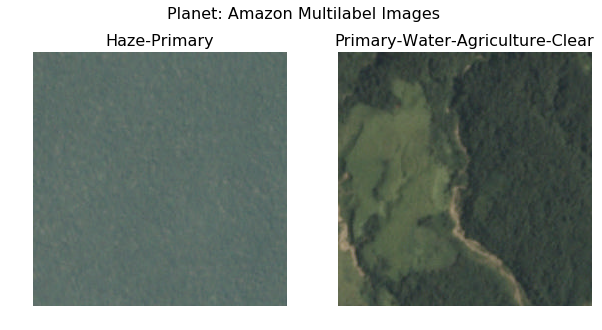

In [6]:
path_list = [f'{PATH}train-jpg/train_0.jpg', f'{PATH}train-jpg/train_1.jpg']
titles = ['Haze-Primary', 'Primary-Water-Agriculture-Clear']
plots_from_files(imspaths= path_list, titles=titles, maintitle= 'Planet: Amazon Multilabel Images')

### 3. Multi-label models for Planet Images - Initial Exploration

In [6]:
# 1. Metrics as directed by Kaggle
from planet import *
metrics = [f2]
arch = resnet34

In [7]:
# 2. Get the Validation indexes 
label_csv = f'{PATH}train_v2.csv'
n= len(list(open(label_csv)))-1
print(n)
val_idxs = get_cv_idxs(n)
print('Validation sample-size: {}'.format(len(val_idxs)))

40479
Validation sample-size: 8095


In [8]:
# 3. Create the get_data function
def get_data(sz, bs):
    tfms = tfms_from_model(f_model=arch, sz=sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', csv_fname= label_csv, bs=bs, tfms=tfms, 
                                       val_idxs=val_idxs, suffix='.jpg',test_name= 'test-jpg')

In [10]:
data = get_data(256, 32)

In [11]:
x, y = next(iter(data.val_dl))

In [12]:
y.size() #its 32 because bs=32, complete iterator size is ([8095, 17])

torch.Size([32, 17])

In [13]:
# 4. Take a look a multilabel sample
list(zip(data.classes, y[0]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 1.0)]

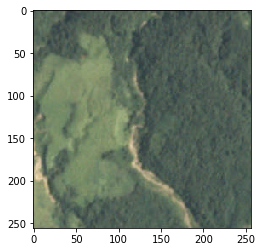

In [43]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4) #Multiplying the image by 1.4 makes is slightly brighter

### 4. We can start to train our models from here 
This competition is not like the ImageNet challenge, so we will have to sort of more liberally retrain by unfreezing the layers 

#### 4.1 We will start with small images - `sz=64`

In [11]:
# Get data with size=64
sz=64
data = get_data(64, 64)

In [12]:
# This step is not necessarily needed. It just makes things faster for larger images that go into the system
data = data.resize(int(sz*1.3), 'tmp')

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [13]:
# Create the Learn object
learn = ConvLearner.pretrained(arch, data, metrics=metrics)

In [14]:
lrf = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.221229   0.2563     0.838091  



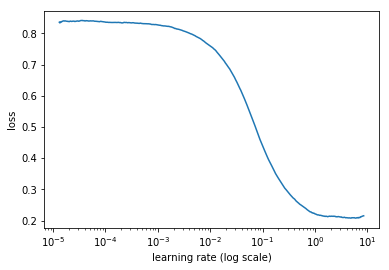

In [15]:
learn.sched.plot()

In [16]:
# Fit using frozen layers 
lr = 0.2

In [17]:
%time learn.fit(lr,3,cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.149222   0.135835   0.880691  
    1      0.140849   0.130078   0.885276                    
    2      0.137866   0.127682   0.8876                      
    3      0.142209   0.12693    0.889208                    
    4      0.13636    0.12566    0.890031                    
    5      0.133298   0.123796   0.892727                    
    6      0.129616   0.12323    0.894593                    

CPU times: user 6min 50s, sys: 2min 4s, total: 8min 55s
Wall time: 4min 52s


[0.12322957, 0.8945933620914072]

In [18]:
# Now lets train with differntial learning rates
lrs= [lr/9, lr/3, lr]
learn.unfreeze()

In [19]:
%time learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.119678   0.110946   0.906794  
    1      0.116242   0.104911   0.912396                    
    2      0.10641    0.1015     0.914692                    
    3      0.112043   0.104283   0.911922                    
    4      0.103534   0.099732   0.916558                    
    5      0.100648   0.098342   0.917069                    
    6      0.100034   0.097923   0.917072                     

CPU times: user 10min 44s, sys: 4min 6s, total: 14min 50s
Wall time: 10min 51s


[0.097923495, 0.9170718847036055]

In [23]:
learn.save(f'resnet34_64') # Saved inside {PATH}/tmp/83/

In [24]:
learn.load(f'resnet34_64')

#### 4.2. Time to increase the image size to `sz=128`

In [25]:
# Get data with the 128x128 spatial size
data = get_data(128,32)
sz=128
data = data.resize(int(sz*1.3),'tmp')

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [26]:
# Configure your learn object with the newest data size
learn.set_data(data)
# You don't want to re-train the initial layers no more 
learn.freeze()
%time learn.fit(lr, 3, cycle_len = 1, cycle_mult= 2)


HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                            
    0      0.105081   0.09838    0.918772  
    1      0.10433    0.098016   0.919212                      
    2      0.105302   0.097076   0.919746                      
    3      0.108438   0.096914   0.920288                      
    4      0.099859   0.096549   0.918887                       
    5      0.106369   0.09552    0.921159                      
    6      0.101569   0.095786   0.921081                      

CPU times: user 21min 15s, sys: 5min 52s, total: 27min 7s
Wall time: 17min 16s


[0.09578565, 0.9210810134606899]

In [ ]:
learn.save(f'resnet34_128')

In [25]:
learn.load(f'resnet34_128')

#### 4.3 Increasing the image size further to `sz=256`

In [26]:
# Get data with the 256x256 spatial size
data = get_data(256,16)
sz=256
data = data.resize(int(sz*1.3),'tmp')

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [27]:
# Configure your learn object with the newest data size
learn.set_data(data)

In [ ]:
# You don't want to re-train the initial layers no more 
learn.freeze()
%time learn.fit(lr, 3, cycle_len = 1, cycle_mult= 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

  8%|▊         | 155/2024 [00:34<06:52,  4.53it/s, loss=0.134]